In [3]:
#Importation des librairies nécessaires au déroulement du projet
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Pour afficher toutes les lignes des données lorsque celles-ci sont affichées dans un tableau ou dans dataframe.
pd.set_option('display.max_rows', None)

### Accès à l'API via token renouvelable chaque 1h et récupération d'une liste des flux de données disponibles via l'API
Le "get feed list" dans l'API ATMO est une fonctionnalité qui à pour objectif principal de fournir aux utilisateurs une vue d'ensemble des données disponibles via l'API. Cela permet aux développeurs et aux utilisateurs de comprendre les différentes sources de données et les types d'informations qu'ils peuvent récupérer à partir de l'API. Dans notre cas, il permet:
- L'exploration des données disponibles : consulter la liste des flux de données pour comprendre les types de données disponibles et les sources de données accessibles via l'API.
- La sélection de données pertinentes : En consultant la liste des flux de données, nous pouvons sélectionner les données pertinentes pour nos besoins spécifiques (la prédiction en exemple) et décider quelles données on souhaitent récupérer via l'API.

In [5]:
#Token fourni par l'API
def get_token_from_file(file_path):

    with open(file_path, 'r') as file:
        data = json.load(file)
        return data.get('token', None)
    
api_key = get_token_from_file('token.json')

In [6]:

# Construction de la requête
url = "https://admindata.atmo-france.org/api/feeds" #fonctionnalité importante qui fournit une vue d'ensemble des données disponibles via l'API
# En-tête de la requête
headers = {
    "Authorization": "Bearer {}".format(api_key)
}

# Envoie de la requête
response = requests.get(url, headers=headers)

# Vérifier le code de réponse
if response.status_code == 200:

    # Analyser la réponse JSON
    data = json.loads(response.content)

    # Afficher les résultats
    for element in data:
        print(element)

else:

    # Gérer l'erreur
    print("Erreur:", response.status_code)

{'feed_type': 'WFS', 'name': 'Indices de qualité de l’air', 'technical_name': 'ind', 'url': 'https://data.atmo-france.org/geoserver/ind/ows?', 'last_update': {'date': '2024-03-05 18:06:01.000000', 'timezone_type': 3, 'timezone': 'Europe/Paris'}, 'layers': [{'name': 'Indice ATMO', 'id': 112, 'technical_name': 'ind:ind_atmo', 'period_selector': 'day', 'update_frequency': 'Quotidienne', 'depth': '1 an glissant', 'pollutant': [{'name': 'indice_atmo_2021.sld', 'id': 456, 'style': 'indice_atmo_2021'}], 'fields': [{'name': 'code_no2', 'type': 'integer'}, {'name': 'code_o3', 'type': 'integer'}, {'name': 'code_pm10', 'type': 'integer'}, {'name': 'code_pm25', 'type': 'integer'}, {'name': 'code_qual', 'type': 'integer'}, {'name': 'code_so2', 'type': 'integer'}, {'name': 'code_zone', 'type': 'text'}, {'name': 'coul_qual', 'type': 'text'}, {'name': 'date_dif', 'type': 'dateiso'}, {'name': 'date_ech', 'type': 'dateiso'}, {'name': 'epsg_reg', 'type': 'text'}, {'name': 'lib_qual', 'type': 'text'}, {'n

# Affichage plus clair de la réponse de l'API
|Nom du flux|Nom technique|URL|Dernière mis à jour|Fuseau horaire|Couches|
|-----------|-------------|---|-------------------|--------------|-------|
|Indices de qualité de l'air|ind|https://www.atmo-france.org/|18/02/2024 à 18:04|Europe/Paris (UTC+1)|indice ATMO|
|Episodes de pollution prévus ou constatés|alrt|https://www.atmo-france.org/article/les-donnees-air-disponibles|19/02/2024 à 11:34|Europe/Paris (UTC+1)|Episodes de pollution constatés pour la veille et le jour même et prévue pour le lendemain, Episodes de pollution constatées sur l’année passée|
|Données émissions|emissions|https://www.atmo-france.org/|15/02/2024 à 14:41|Europe/Paris (UTC+1)|Établissements publics de coopération intercommunale (EPCI), Région|

## Détail des couches
### Indice ATMO:
- Polluants: indice_atmo_2021.sld
- Champs: code_no2, code_o3, code_pm10, code_pm25, code_qual, code_so2, code_zone, coul_qual, date_dif, date_ech, epsg_reg, lib_qual, lib_zone, source, type_zone, x_reg, x_wgs84, y_reg, y_wgs84
### Episodes de pollution constatés pour la veille et le jour même et prévue pour le lendemain:
- Pas de polluants
- Champs: etat, lib_zone, lib_pol, date_dif
### Episodes de pollution constatées sur l’année passée:
- Pas de polluants
- Champs: lib_pol, lib_zone, etat, date_ech, date_dif, code_zone, code_pol
### Établissements publics de coopération intercommunale (EPCI):
- Pas de polluants
- Champs: superficie, population, pm25, pm10, nox, code_pcaet, ges, code
### Région:
- Pas de polluants
- Champs: superficie, population, pm25, pm10, nox, ges, code_pcaet, code

Dans la suite de notre rapport, nous nous sommes interessé aux donnnées de la région de caen depuis les années 2022.
La première donnée collectée est l'indice de qualité de l'air aveec comme couche "indice ATMO" qui présente plusieurs champs comme détaillé dans le markdown précédent.

In [36]:
def format_data(commune_data):
    # Rename columns starting with "properties."
    commune_data.rename(columns=lambda x: x.replace("properties.", ""), inplace=True)
        
    return commune_data

In [37]:
def fetch_data(api_key, id_data, params):

    # Construction de l'URL avec l'identifiant de la donnée
    url = f"https://admindata.atmo-france.org/api/data/{id_data}/"
    
    # Convertir les paramètres en une chaîne JSON et les ajouter à l'URL
    url += json.dumps(params)
    
    url += "?withGeom=false"
    
    headers = {
        "Authorization": f"Bearer {api_key}"
    }
    
    response = requests.get(url, headers=headers)
       
    if response.status_code == 200:
        data = json.loads(response.content)
        return pd.json_normalize(data['features']), response.status_code
    elif response.status_code == 401 or response.status_code == 400: 
        #sys.exit(f"Erreur: {response.status_code}") 
        return None, response.status_code
    else:
        return None, response.status_code
        #sys.exit(f"Erreur: {response.status_code}")  

In [51]:
def fetch_commune(api_key, id_data, start_date, commune_code, code_insee_file):
  # Define the parameters for the query
  params = {
      "code_zone": {"operator": "=", "value": commune_code},
      "date_ech": {"operator": ">=", "value": start_date}
  }
  # Fetch data for the current commune
  commune_data, status_api = fetch_data(api_key, id_data, params)
  # Format and return data if available
  if commune_data is not None and not commune_data.empty:
    return format_data(commune_data)
  else:
    if status_api == 400 or status_api == 401:
        sys.exit("Renouveler le token")
    return None



In [52]:
#Le type de données à recupérer (112: indice qualité de l'air) 
id_data = 112 
# Date de début de la plage de recherche, la date de fin est au moment d'exécution de la requête
start_date = "01-01-2023"
# fichier contenant dans les codes insee, des communes, départements et régions.
# Mais aussi des colonnes supplémentaires pour chaque id_data pour vérifier les 
# communes/régions déja balayés pour l'id_data spécifique.
code_insee_file = "commune_insee.xlsx"
commune_code = 14118

In [53]:
data_ind = fetch_commune(api_key, id_data, start_date, commune_code, code_insee_file)

ok!


In [54]:
# Afficher le DataFrame
data_ind

,type,geometry,gml_id,aasqa,date_maj,partition_field,code_no2,code_o3,code_pm10,code_pm25,...,date_ech,epsg_reg,lib_qual,lib_zone,source,type_zone,x_reg,x_wgs84,y_reg,y_wgs84
0,Feature,None,229702384,28,2021/09/16 18:14:20.882+02,282021w1,2,1,2,2,...,2021-01-08,2154,Moyen,Caen,Atmo Normandie,commune,454137.406,-0.372857,6903186.0,49.181152
1,Feature,None,229864216,28,2021/09/16 18:14:20.882+02,282021w1,2,1,2,4,...,2021-01-06,2154,Mauvais,Caen,Atmo Normandie,commune,454137.406,-0.372857,6903186.0,49.181152
2,Feature,None,229661243,28,2021/09/16 18:14:20.882+02,282021w10,1,2,2,1,...,2021-03-14,2154,Moyen,Caen,Atmo Normandie,commune,454137.406,-0.372857,6903186.0,49.181152
3,Feature,None,229752767,28,2021/09/16 18:14:20.882+02,282021w10,1,2,1,1,...,2021-03-11,2154,Moyen,Caen,Atmo Normandie,commune,454137.406,-0.372857,6903186.0,49.181152
4,Feature,None,229845895,28,2021/09/16 18:14:20.882+02,282021w10,1,2,1,1,...,2021-03-13,2154,Moyen,Caen,Atmo Normandie,commune,454137.406,-0.372857,6903186.0,49.181152
5,Feature,None,229887053,28,2021/09/16 18:14:20.882+02,282021w10,1,2,2,1,...,2021-03-14,2154,Moyen,Caen,Atmo Normandie,commune,454137.406,-0.372857,6903186.0,49.181152
6,Feature,None,230013017,28,2021/09/16 18:14:20.882+02,282021w10,2,2,2,3,...,2021-03-08,2154,Dégradé,Caen,Atmo Normandie,commune,454137.406,-0.372857,6903186.0,49.181152
7,Feature,None,229462056,28,2021/09/16 18:14:20.882+02,282021w11,1,2,1,2,...,2021-03-19,2154,Moyen,Caen,Atmo Normandie,commune,454137.406,-0.372857,6903186.0,49.181152
8,Feature,None,229462389,28,2021/09/16 18:14:20.882+02,282021w11,1,2,1,2,...,2021-03-21,2154,Moyen,Caen,Atmo Normandie,commune,454137.406,-0.372857,6903186.0,49.181152
9,Feature,None,229487173,28,2021/09/16 18:14:20.882+02,282021w11,1,2,1,2,...,2021-03-19,2154,Moyen,Caen,Atmo Normandie,commune,454137.406,-0.372857,6903186.0,49.181152


In [55]:
data_ind.shape

(521, 25)

L'API renvoies 186 unités statistiques composées chacune de 25 caractères ou variables caractéristiques.(cas de l'indice ATMO)
- type: Ce champ spécifie le type de géométrie des données. Il peut indiquer le type de données géospatiales, telles que les polygones, les points ou les lignes.

- geometry: Ce champ contient les données géométriques associées à la donnée, par exemple, les coordonnées géographiques d'un point ou les coordonnées des sommets d'un polygone.

- properties.gml_id: C'est un identifiant unique pour chaque entité géospatiale. Il est généralement utilisé pour référencer et identifier chaque entité de manière unique.

- properties.aasqa: Ce champ contient des informations sur la qualité de l'air associée à l'entité géospatiale. Il peut s'agir d'un indice de qualité de l'air ou d'autres mesures de la pollution atmosphérique.

- properties.date_maj: Il s'agit de la date de mise à jour des données, indiquant quand les données ont été dernièrement mises à jour ou modifiées.

- properties.partition_field: Ce champ peut être utilisé pour partitionner les données en fonction de certains critères ou attributs, généralement utilisé pour l'organisation des données dans la base de données.

- properties.code_no2, properties.code_o3, properties.code_pm10, properties.code_pm25, properties.code_qual, properties.code_so2: Ce sont les codes correspondant aux concentrations des différents polluants atmosphériques mesurés (dioxyde d'azote, ozone, particules en suspension de diamètre inférieur à 10 µm, particules en suspension de diamètre inférieur à 2.5 µm, dioxyde de soufre).

- properties.code_zone: Il s'agit d'un code identifiant la zone géographique à laquelle l'entité appartient, par exemple, un code INSEE pour une commune.

- properties.coul_qual: Ce champ contient la couleur associée à la qualité de l'air pour l'entité géospatiale, utilisée par exemple dans des visualisations cartographiques.

- properties.date_dif, properties.date_ech: Ces champs représentent respectivement la date de différence et la date d'échéance des données.

- properties.epsg_reg: Ce champ indique le système de référence de coordonnées utilisé pour représenter les données géographiques.

- properties.lib_qual: Ce champ contient une description textuelle de la qualité de l'air, par exemple, "Bonne", "Moyenne", "Mauvaise", etc.

- properties.lib_zone: Ce champ représente le nom de la zone géographique associée à chaque entité géospatiale.

- properties.source: Il s'agit de la source des données, par exemple, "Atmo France".

- properties.type_zone: Ce champ indique le type de zone géographique, par exemple, "commune".

- properties.x_reg, properties.y_reg, properties.x_wgs84, properties.y_wgs84: Ces champs représentent les coordonnées géographiques de chaque entité dans différents systèmes de coordonnées (par exemple, Lambert 93 et WGS 84).

In [56]:
data_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             521 non-null    object 
 1   geometry         0 non-null      object 
 2   gml_id           521 non-null    int64  
 3   aasqa            521 non-null    object 
 4   date_maj         521 non-null    object 
 5   partition_field  521 non-null    object 
 6   code_no2         521 non-null    int64  
 7   code_o3          521 non-null    int64  
 8   code_pm10        521 non-null    int64  
 9   code_pm25        521 non-null    int64  
 10  code_qual        521 non-null    int64  
 11  code_so2         521 non-null    int64  
 12  code_zone        521 non-null    object 
 13  coul_qual        521 non-null    object 
 14  date_dif         521 non-null    object 
 15  date_ech         521 non-null    object 
 16  epsg_reg         521 non-null    object 
 17  lib_qual        

Nous notons 186 valeurs manquantes pour la variable géometry, ce qui est tout à fait normal puisque nous l'avons mentionner dans notre requête: "?withGeom=false"
De façon logique, nous pouvons noter l'absence d'observations sur un certains nombres de jours, mais dans la réponse de l'API nous remarquons aucune valeur manquante à part celle de la variable géometry. Il peut donc arriver que pour certaine région, nous ayons pas les observations d'une ou plusieurs journées sur l'ensemble de la période ciblée. 

In [57]:
# comptabiliser le nombre de valeurs manquantes par variable
data_ind.isnull().sum()

type                 0
geometry           521
gml_id               0
aasqa                0
date_maj             0
partition_field      0
code_no2             0
code_o3              0
code_pm10            0
code_pm25            0
code_qual            0
code_so2             0
code_zone            0
coul_qual            0
date_dif             0
date_ech             0
epsg_reg             0
lib_qual             0
lib_zone             0
source               0
type_zone            0
x_reg                0
x_wgs84              0
y_reg                0
y_wgs84              0
dtype: int64

In [58]:
# Vérifier les doublons dans le DataFrame
duplicates = data_ind.duplicated()

# Afficher les lignes du DataFrame qui sont des doublons
print(data_ind[duplicates])

Empty DataFrame
Columns: [type, geometry, gml_id, aasqa, date_maj, partition_field, code_no2, code_o3, code_pm10, code_pm25, code_qual, code_so2, code_zone, coul_qual, date_dif, date_ech, epsg_reg, lib_qual, lib_zone, source, type_zone, x_reg, x_wgs84, y_reg, y_wgs84]
Index: []

[0 rows x 25 columns]


Nous notons aucun doublon

In [59]:
#Statistique descriptive pour la detection des outliers
data_ind.describe()

,gml_id,code_no2,code_o3,code_pm10,code_pm25,code_qual,code_so2,x_reg,x_wgs84,y_reg,y_wgs84
count,5.210000e+02,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,5.210000e+02,5.210000e+02,521.0,5.210000e+02
mean,7.733022e+08,1.310940,2.065259,1.268714,1.477927,2.193858,0.788868,4.541374e+05,-3.728569e-01,6903186.0,4.918115e+01
std,6.438585e+08,0.479639,0.391696,0.512122,0.736410,0.510317,0.408504,3.728871e-09,1.611371e-15,0.0,2.702657e-13
min,2.293390e+08,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.541374e+05,-3.728569e-01,6903186.0,4.918115e+01
25%,2.296955e+08,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,4.541374e+05,-3.728569e-01,6903186.0,4.918115e+01
50%,3.905796e+08,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,4.541374e+05,-3.728569e-01,6903186.0,4.918115e+01
75%,1.397109e+09,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,4.541374e+05,-3.728569e-01,6903186.0,4.918115e+01
max,2.070800e+09,3.000000,4.000000,4.000000,4.000000,4.000000,1.000000,4.541374e+05,-3.728569e-01,6903186.0,4.918115e+01


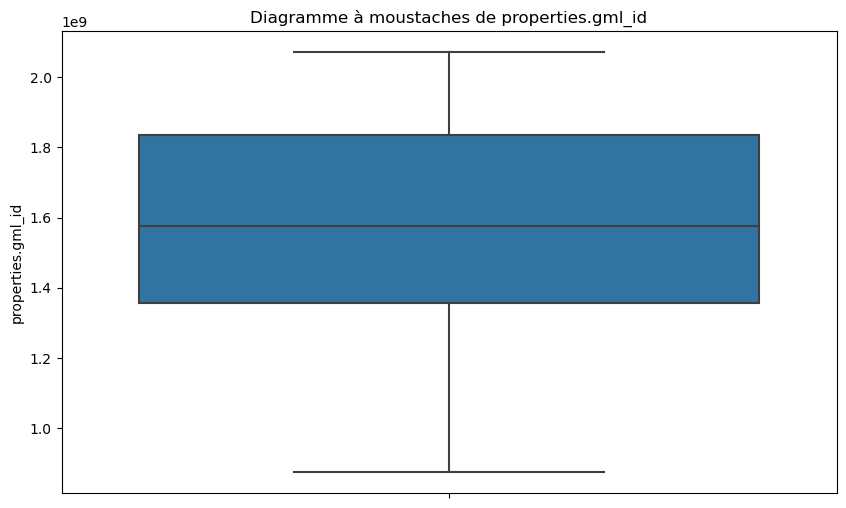

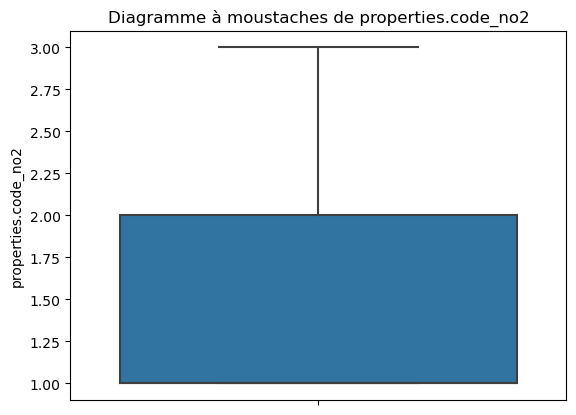

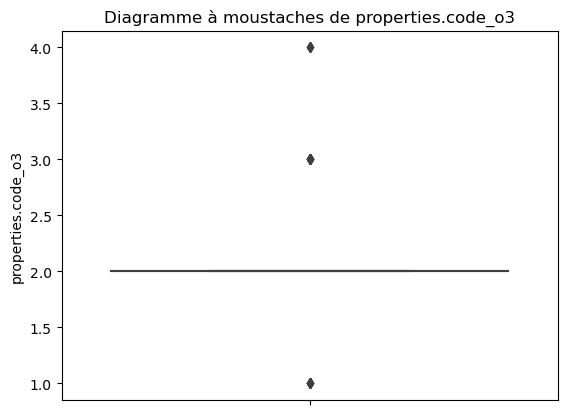

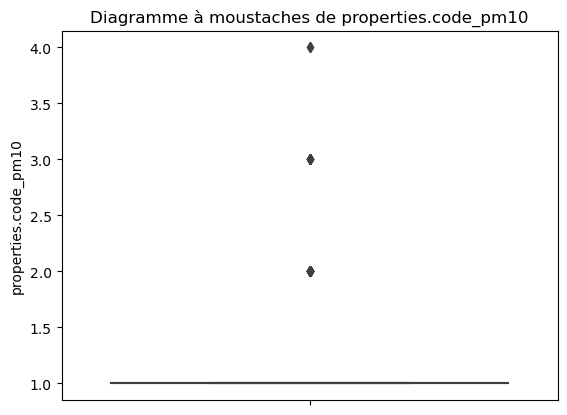

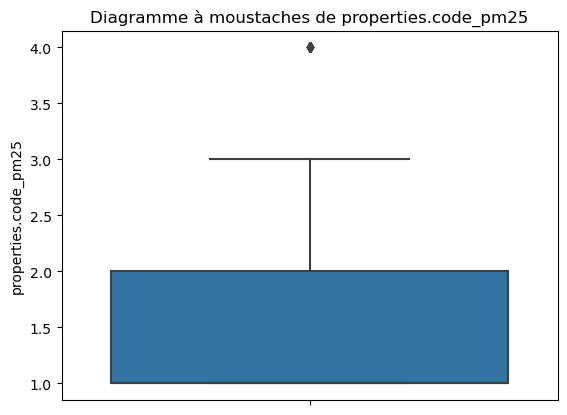

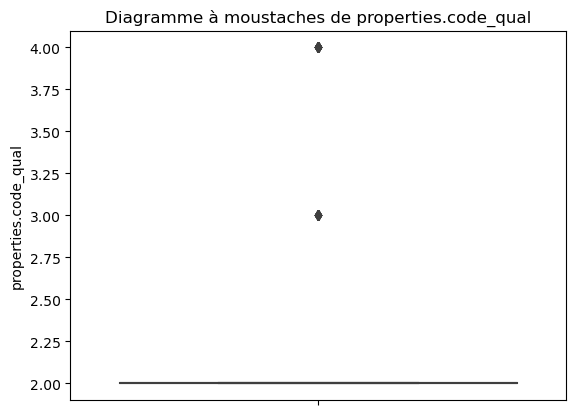

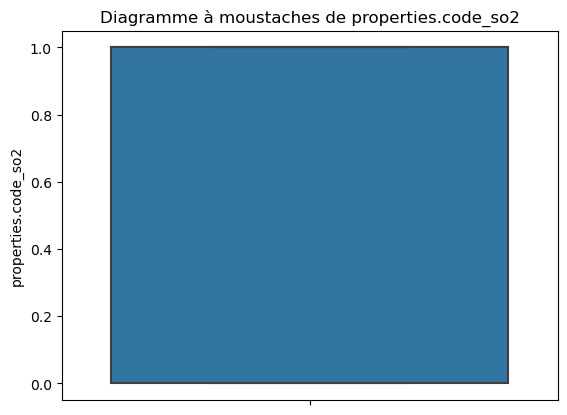

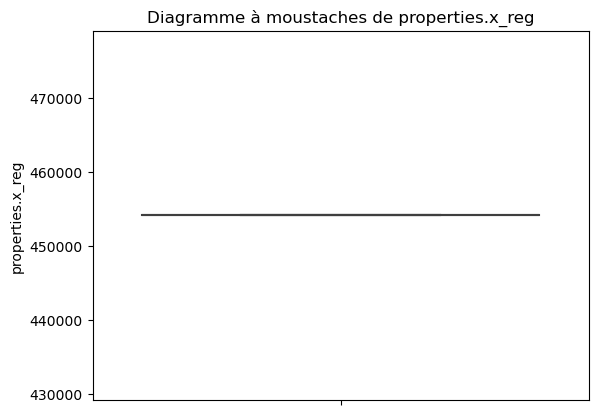

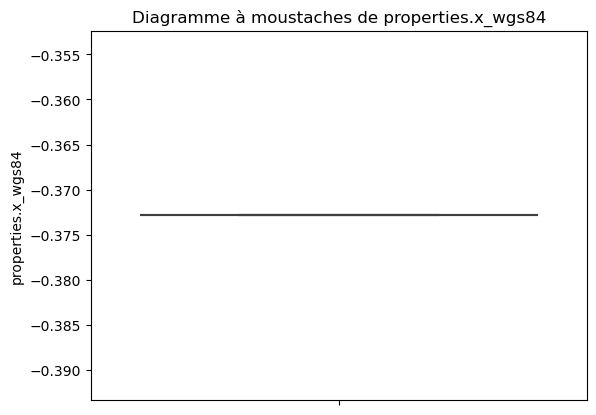

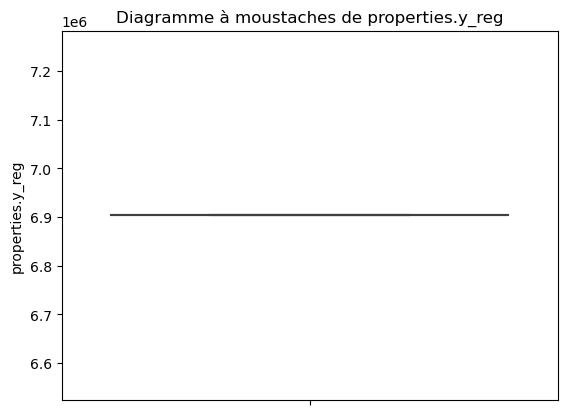

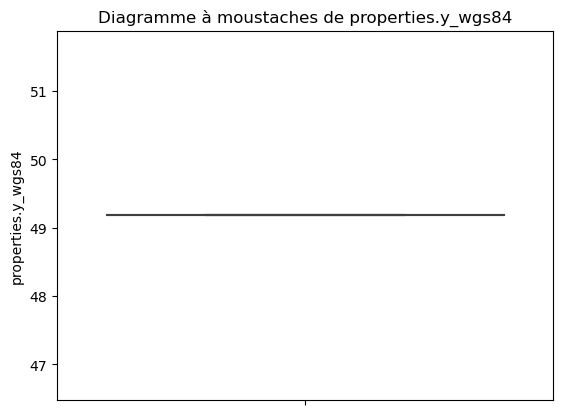

In [19]:
def plot_boxplots(dataframe):
    numerical_columns = dataframe.select_dtypes(include=['number']).columns.tolist()
    plt.figure(figsize=(10, 6))
    for column in numerical_columns:
        sns.boxplot(y=column, data=dataframe)
        plt.title(f'Diagramme à moustaches de {column}')
        plt.show()

# Créons un diagramme à moustaches pour chaque variable numérique
plot_boxplots(data_ind)

In [60]:
#covariance entre toutes les paires de variables numériques présentes dans le DataFrame
data_ind.cov()

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_13928\4237434226.py:2: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_ind.cov()


,gml_id,code_no2,code_o3,code_pm10,code_pm25,code_qual,code_so2,x_reg,x_wgs84,y_reg,y_wgs84
gml_id,4.145537e+17,2.220620e+07,-9.709963e+06,-4.804712e+06,1.353507e+07,1.849109e+07,-7.691537e+07,-1.742196e-16,8.307439e-23,0.0,0.0
code_no2,2.220620e+07,2.300532e-01,6.592352e-03,9.128525e-02,1.107227e-01,7.229810e-02,-3.422413e-02,-3.201348e-26,1.526522e-32,0.0,0.0
code_o3,-9.709963e+06,6.592352e-03,1.534254e-01,3.627639e-02,2.836631e-02,9.886313e-02,8.035582e-03,-2.823549e-26,1.346373e-32,0.0,0.0
code_pm10,-4.804712e+06,9.128525e-02,3.627639e-02,2.622693e-01,2.847889e-01,1.804998e-01,-1.431050e-02,-2.187256e-26,1.042965e-32,0.0,0.0
code_pm25,1.353507e+07,1.107227e-01,2.836631e-02,2.847889e-01,5.423003e-01,2.783257e-01,-2.966928e-02,-2.167372e-26,1.213632e-32,0.0,0.0
code_qual,1.849109e+07,7.229810e-02,9.886313e-02,1.804998e-01,2.783257e-01,2.604237e-01,-7.068507e-03,-1.988415e-26,9.481501e-33,0.0,0.0
code_so2,-7.691537e+07,-3.422413e-02,8.035582e-03,-1.431050e-02,-2.966928e-02,-7.068507e-03,1.668758e-01,1.193049e-26,-6.447421e-33,0.0,0.0
x_reg,-1.742196e-16,-3.201348e-26,-2.823549e-26,-2.187256e-26,-2.167372e-26,-1.988415e-26,1.193049e-26,1.357859e-20,-6.474776e-27,0.0,0.0
x_wgs84,8.307439e-23,1.526522e-32,1.346373e-32,1.042965e-32,1.213632e-32,9.481501e-33,-6.447421e-33,-6.474776e-27,3.087414e-33,0.0,0.0
y_reg,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0


In [61]:
#vérification de la corrélation des colonnes
data_ind.corr()

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_13928\2437835073.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_ind.corr()


,gml_id,code_no2,code_o3,code_pm10,code_pm25,code_qual,code_so2,x_reg,x_wgs84,y_reg,y_wgs84
gml_id,1.000000,0.071907,-0.038502,-0.014571,0.028546,0.056277,-0.292433,NaN,NaN,NaN,NaN
code_no2,0.071907,1.000000,0.035090,0.371632,0.313475,0.295374,-0.174671,NaN,NaN,NaN,NaN
code_o3,-0.038502,0.035090,1.000000,0.180843,0.098341,0.494590,0.050219,NaN,NaN,NaN,NaN
code_pm10,-0.014571,0.371632,0.180843,1.000000,0.755143,0.690657,-0.068404,NaN,NaN,NaN,NaN
code_pm25,0.028546,0.313475,0.098341,0.755143,1.000000,0.740616,-0.098626,NaN,NaN,NaN,NaN
code_qual,0.056277,0.295374,0.494590,0.690657,0.740616,1.000000,-0.033907,NaN,NaN,NaN,NaN
code_so2,-0.292433,-0.174671,0.050219,-0.068404,-0.098626,-0.033907,1.000000,NaN,NaN,NaN,NaN
x_reg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x_wgs84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_reg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


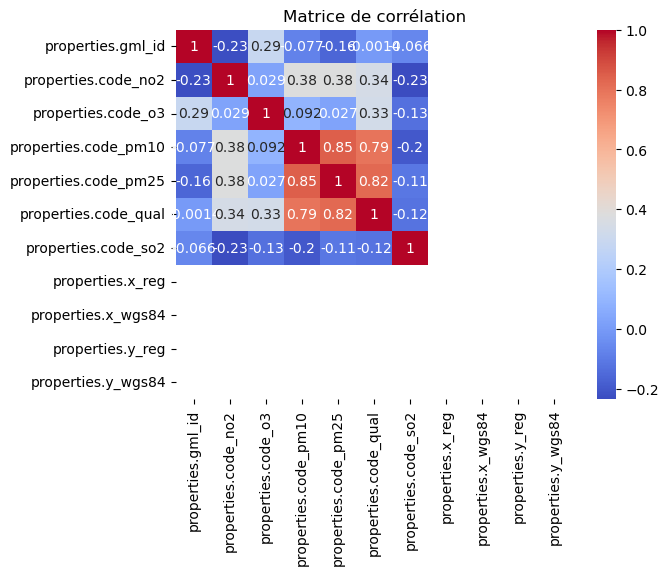

In [16]:
# Affichons la matrice de corrélation sous forme de heatmap
sns.heatmap(data_ind.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

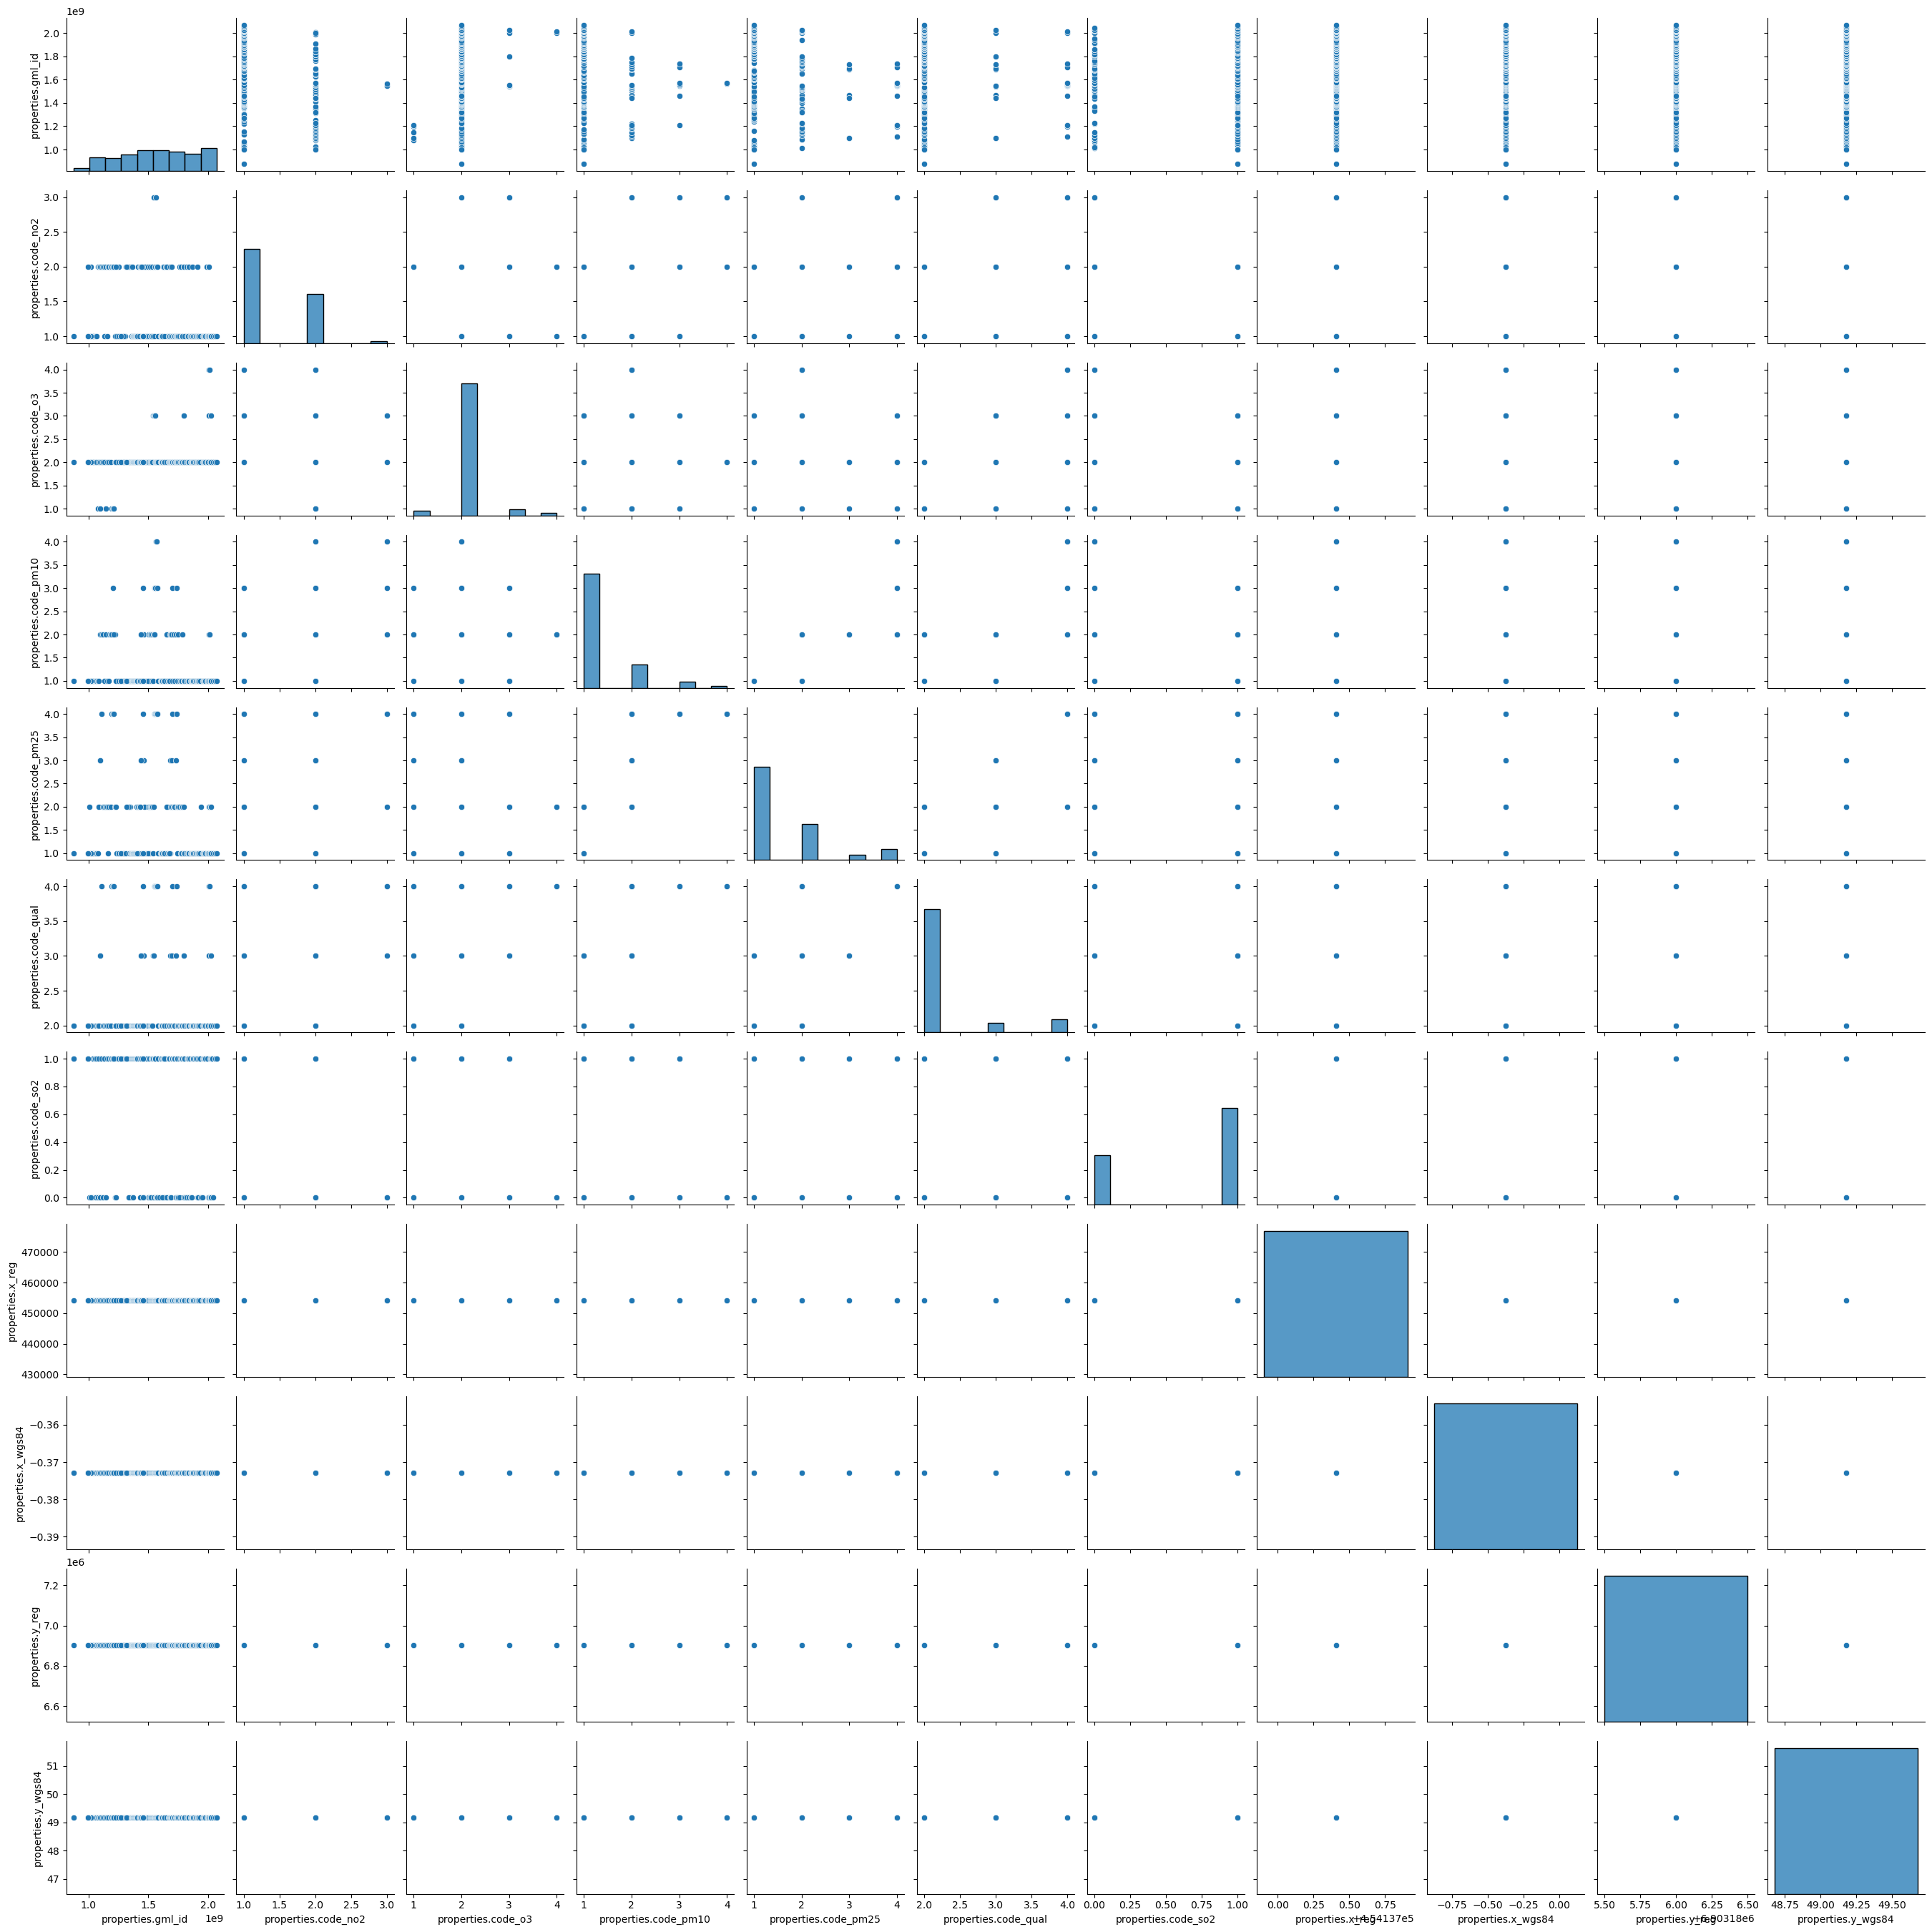

In [17]:
numerical_columns = data_ind.select_dtypes(include=['int64', 'float64']).columns

# Créons un diagramme de dispersion pour chaque paire de colonnes numériques
sns.pairplot(data_ind[numerical_columns])
plt.show()

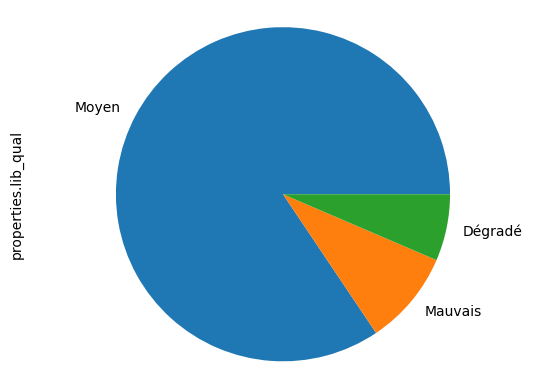

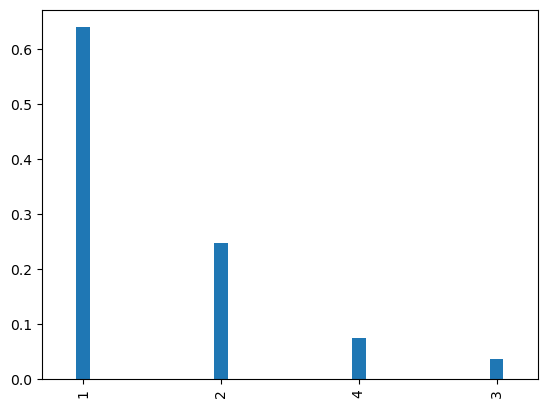

In [18]:
def plot_variable_diagrams(dataframe):
    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            # Diagramme en secteurs pour variable qualitative
            dataframe[column].value_counts(normalize=True).plot(kind='pie')
            plt.title(f"Pie chart for variable '{column}'")
            plt.axis('equal') 
            plt.show()
        else:
            # Diagramme en bâtons pour variable quantitative
            dataframe[column].value_counts(normalize=True).plot(kind='bar', width=0.1)
            plt.title(f"Bar chart for variable '{column}'")
            plt.show()

#Exemple d'utilisation
plot_variable_diagrams(data_ind)